In [40]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
sys.path.append('..')
from tiger.patches import PatchExtractor3D
from load_data import load_masks
from config import *
from monai.transforms import Compose, RandRotate, RandZoom

In [98]:
class DatasetMask(torch.utils.data.Dataset):
    """"
    Dataset of corrupted and original patches. Corruption is done by removing healthy vertebrae at the center of the
    patch.
    TODO: add data augmentation
    """
    def __init__(self, scores, masks, patch_size, transforms=False):
        self.original_masks = []
        self.corrupted_masks = []
        self.transforms = transforms

        for row, mask in enumerate(tqdm(masks)):
            vert_scores = scores.iloc[row][2:].to_numpy().reshape(18, 2).astype(float)
            mask_unique = np.unique(mask)

            for i, vert_score in enumerate(vert_scores):
                if not (np.isnan(vert_score).any()):
                    grade = vert_score[0]
                    vert = i + 1

                    # only add healthy ones that are also present in the mask
                    if vert in mask_unique and grade == 0:
                        centre = tuple(np.mean(np.argwhere(mask == vert), axis=0, dtype=int))
                        patch_extracter_msk = PatchExtractor3D(mask)
                        m = patch_extracter_msk.extract_cuboid(centre, patch_size)
                        z = np.where(m == vert, 0, m > 0)      # remove this vert
                        m = np.where(m > 0, 1, 0)              # make binary mask
                        self.original_masks.append(m)
                        self.corrupted_masks.append(z)

    def __len__(self):
        """
        Returns N, the number of samples in this dataset.
        """
        return len(self.original_masks)

    def __getitem__(self, ind):
        """"
        Return a single sample:
        """     
        m = self.original_masks[ind]
        z = self.corrupted_masks[ind]
        
        # apply transform on both orignal and corruption
        spatial_transforms = Compose([RandZoom(prob=1, min_zoom=0.75, max_zoom=1.25, mode='trilinear', padding_mode='minimum'),
                                      RandRotate(prob=1, range_x=0.3, range_y=0.3, range_z=0, mode="bilinear", padding_mode='zeros')])
                             
        x = spatial_transforms(np.stack((m, z)))
        
        m = torch.tensor(m, dtype=torch.float32).unsqueeze(0)
        z = torch.tensor(z, dtype=torch.float32).unsqueeze(0)
        
        m_trans = torch.tensor(x[0], dtype=torch.float32).unsqueeze(0)
        z_trans = torch.tensor(x[1], dtype=torch.float32).unsqueeze(0)
                               
        return m, z, m_trans, z_trans

In [18]:
masks, scores = load_masks(verse2019_dir, cases=5)

Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/masks_bodies...


  0%|          | 0/5 [00:00<?, ?it/s]

In [99]:
dataset = DatasetMask(scores, masks, patch_size=patch_size, transforms=True)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

  0%|          | 0/5 [00:00<?, ?it/s]

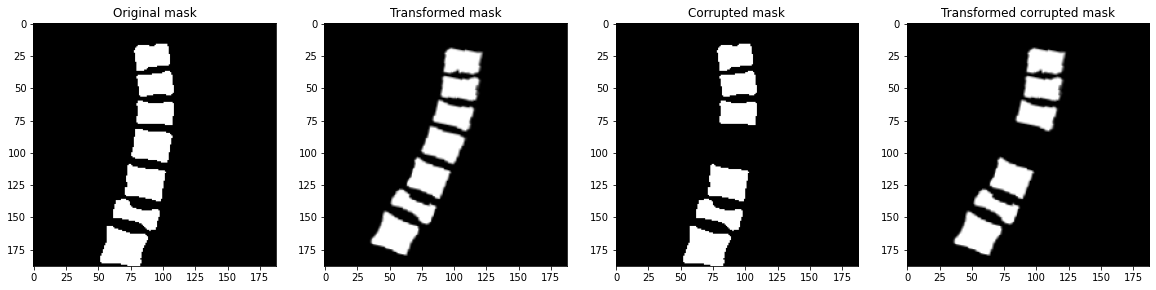

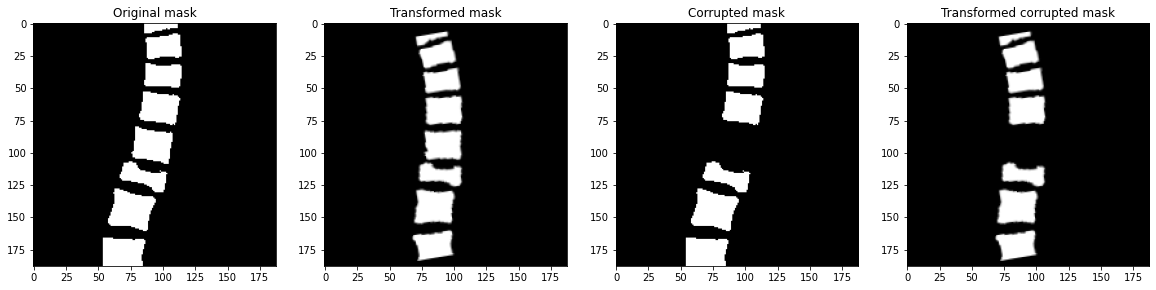

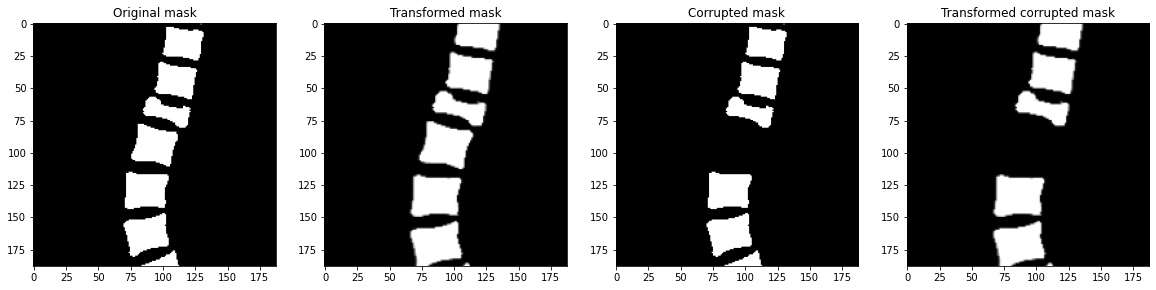

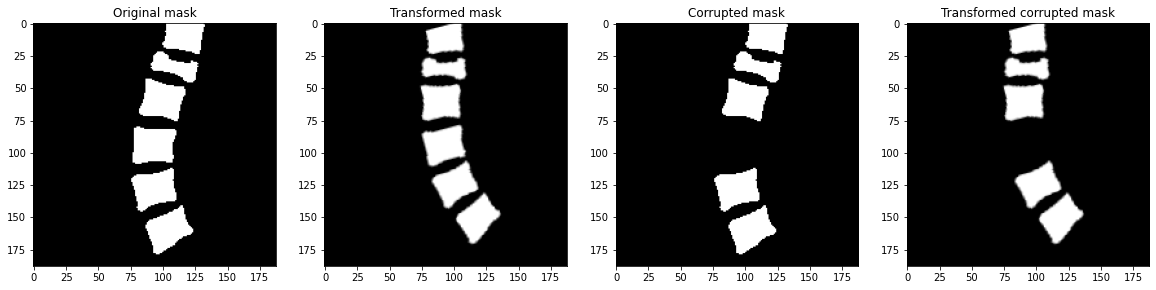

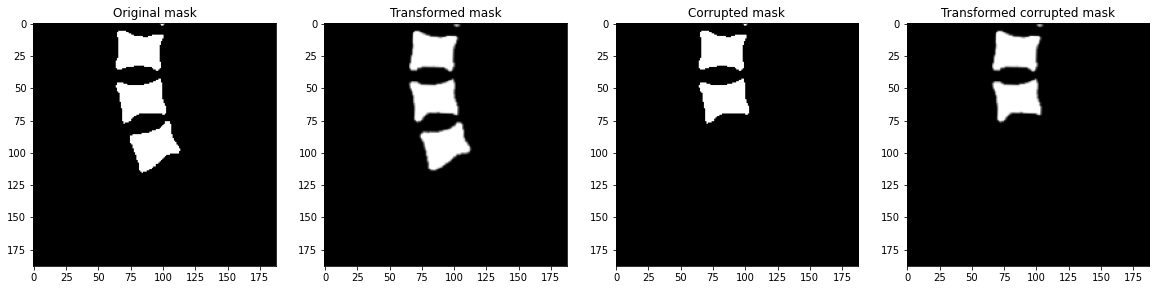

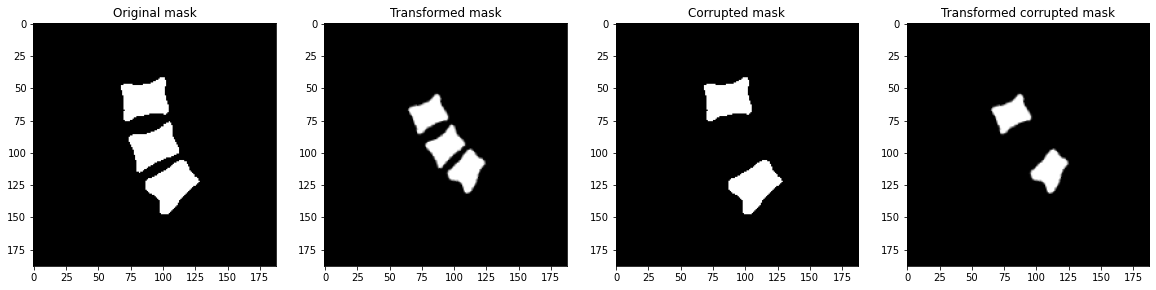

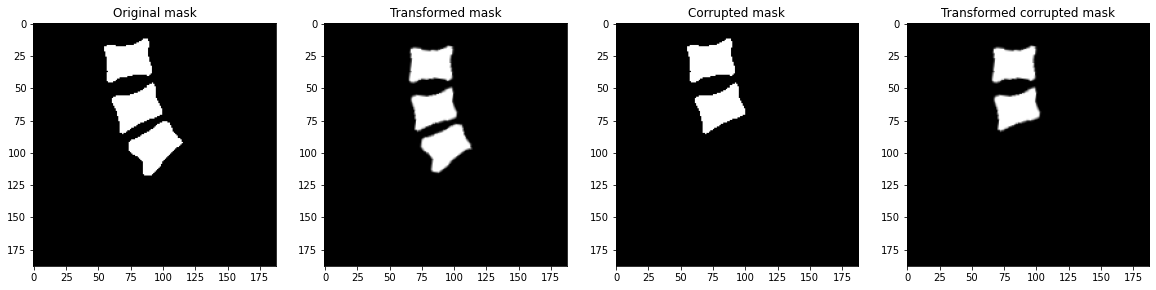

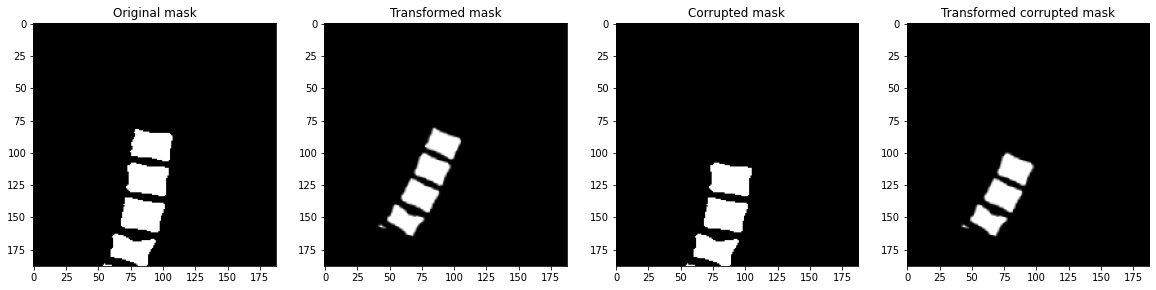

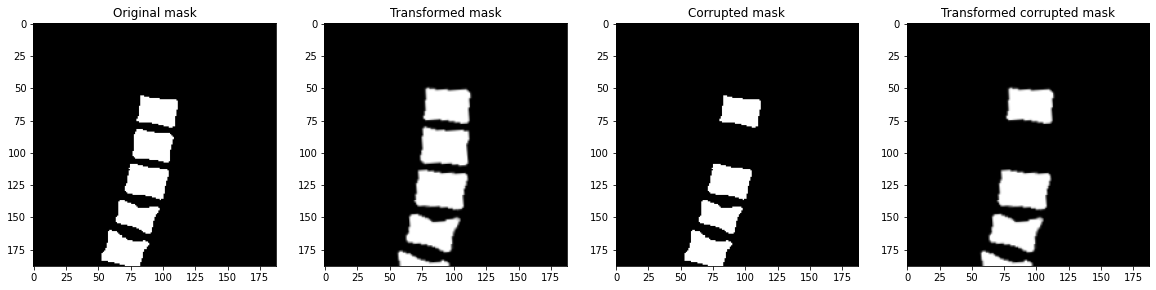

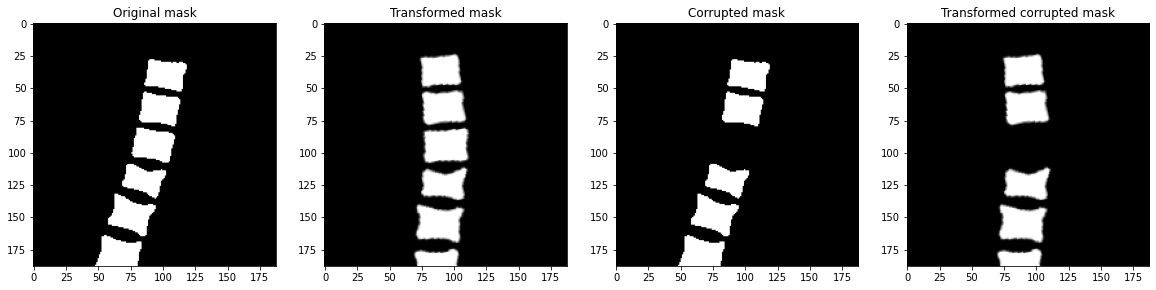

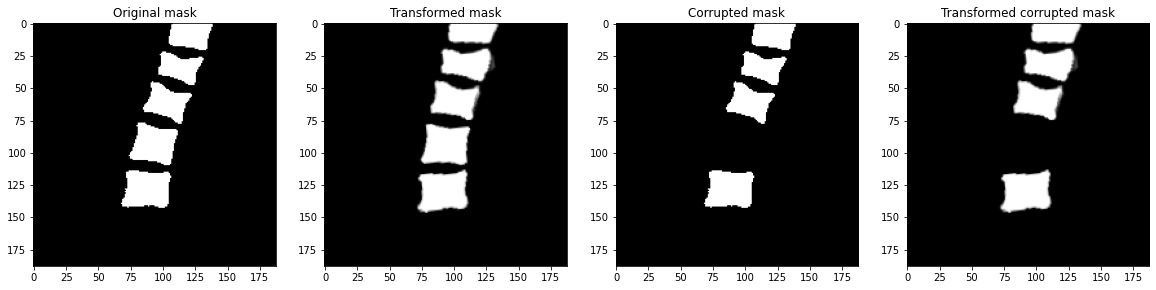

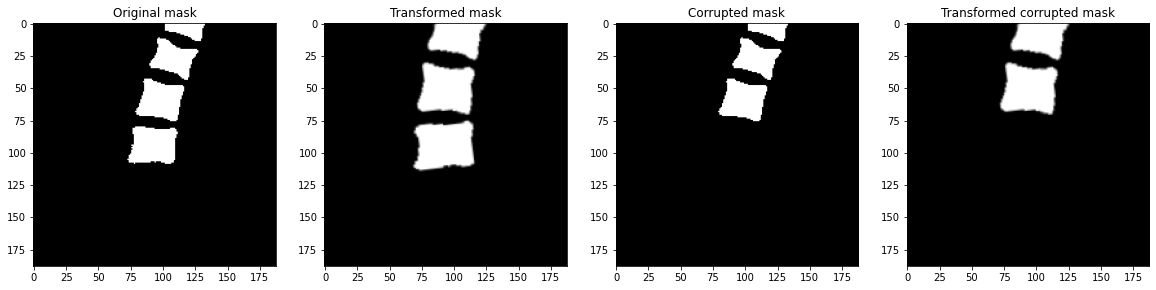

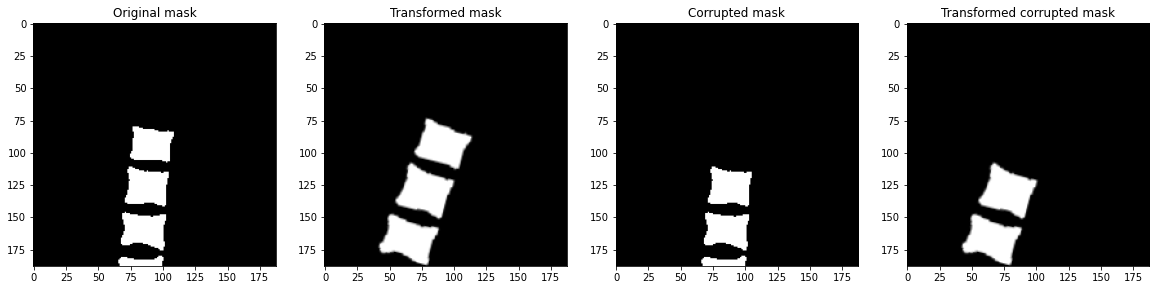

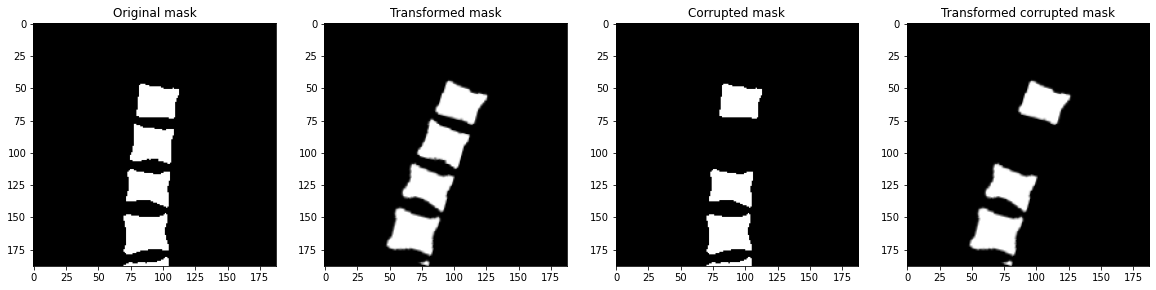

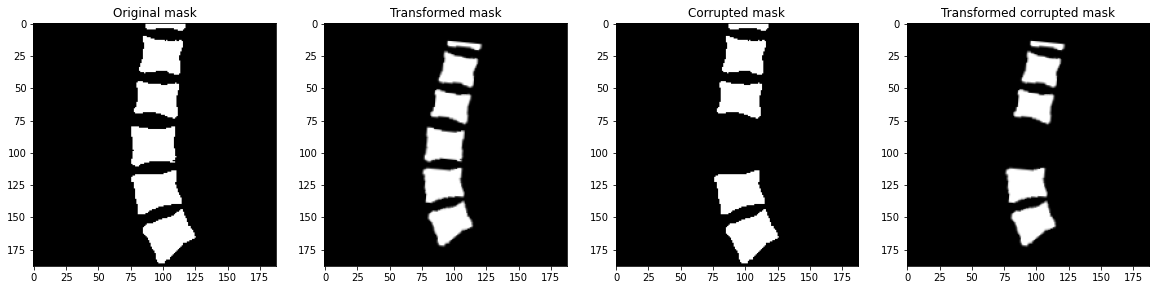

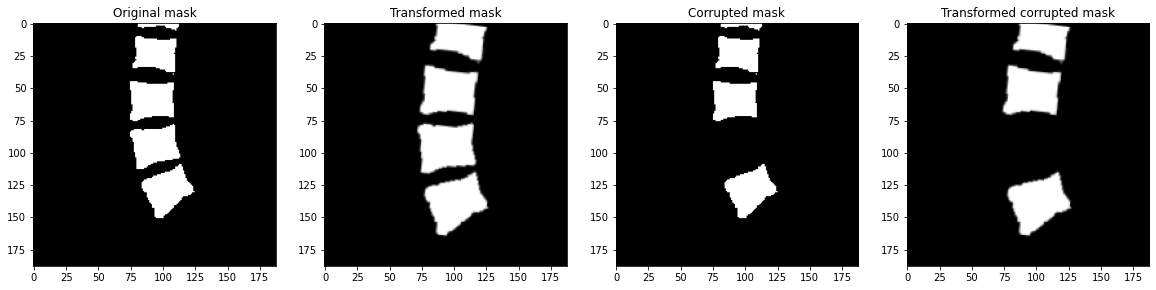

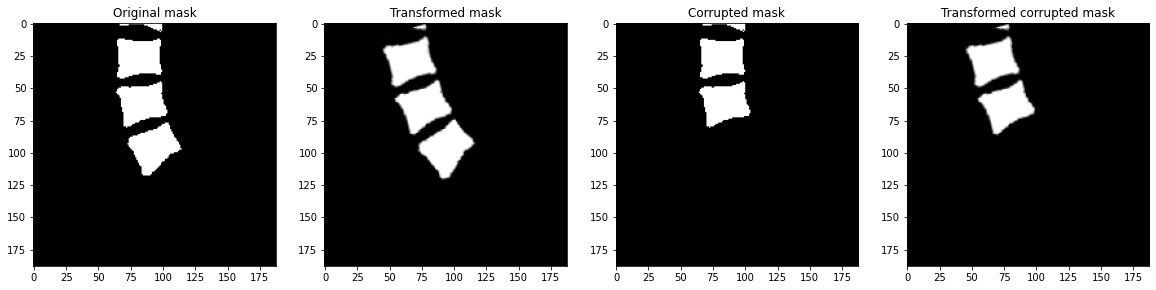

In [100]:
for m, z, m_trans, z_trans in loader:
    m, z, m_trans, z_trans = m.squeeze(), z.squeeze(), m_trans.squeeze(), z_trans.squeeze()
     
    mid_slice = m.shape[0] // 2 
    plt.figure(figsize=(20, 12))
    plt.subplot(141)
    plt.gca().set_title('Original mask')
    plt.imshow(m[mid_slice, :, :], cmap='gray')
    plt.subplot(142)
    plt.gca().set_title('Transformed mask')
    plt.imshow(m_trans[mid_slice, :, :], cmap='gray')
    plt.subplot(143)
    plt.gca().set_title('Corrupted mask')
    plt.imshow(z[mid_slice, :, :], cmap='gray')
    plt.subplot(144)
    plt.gca().set_title('Transformed corrupted mask')
    plt.imshow(z_trans[mid_slice, :, :], cmap='gray')